### Question: Can we predict customer churn based on billing information (Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, and TotalCharges)?

##### Expectations
 This can be a useful question for the telecommunications company, as it can help them to understand which factors are most important in driving customer churn and how they can take targeted actions to reduce churn rates. By analyzing the data and building a predictive model, the company can gain insights into which billing methods are most strongly associated with churn, and use this information to develop retention strategies that are tailored to different customer segments.

##### Information about the data
The data is stored in an Excel file named `Telco_customer_churn_services.xlsx`. The file contains 7043 rows. Each row represents a customer, each column contains customer’s attributes described on the column Metadata. The billing features that we have are: 
1. Contract
2. PaperlessBilling
3. PaymentMethod
4. MonthlyCharges
5. TotalCharges

### EDA

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from imblearn.over_sampling import SMOTE

from utils import *

In [3]:
# Importing the dataset
dataset1 = pd.read_excel('../../DataSet/Telco_customer_churn_services.xlsx')

In [4]:
# we need to get a column from another excel file and join it with the dataset

# Load the data from /Dataset/Telco_customer_churn.xlsx
dataset2 = pd.read_excel('../../DataSet/Telco_customer_churn.xlsx')

In [5]:
print(dataset1.columns)
print(dataset2.columns)

Index(['Customer ID', 'Count', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue'],
      dtype='object')
Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Su

##### Clean and Prepare the data

In [6]:
# rename the column to match the column name in the dataset1
dataset2.rename(columns={'CustomerID':'Customer ID'}, inplace=True)

In [7]:
# Join the two datasets on the column 'Customer ID'
dataset = pd.merge(dataset1, dataset2, on='Customer ID')

In [8]:
dataset.columns

Index(['Customer ID', 'Count_x', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service_x',
       'Avg Monthly Long Distance Charges', 'Multiple Lines_x',
       'Internet Service_x', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security_x', 'Online Backup_x', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV_x', 'Streaming Movies_x',
       'Streaming Music', 'Unlimited Data', 'Contract_x',
       'Paperless Billing_x', 'Payment Method_x', 'Monthly Charge',
       'Total Charges_x', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Count_y', 'Country',
       'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude',
       'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service_y', 'Multiple Lines_y', 'Internet Service_y',
       'Online Security_y', 'Online Backup_y', 'Device Protection',
       'Tech Sup

In [9]:
# take only the columns that we need
# these columns are Contract_x, Paperless Billing, Payment Method, Monthly Charges, Total Charges, Churn Value
dataset = dataset[['Contract_x', 'Paperless Billing_x', 'Payment Method_x', 'Monthly Charges', 'Total Charges_x', 'Churn Value']]

In [10]:
# Check for any missing values
dataset.isnull().sum()

Contract_x             0
Paperless Billing_x    0
Payment Method_x       0
Monthly Charges        0
Total Charges_x        0
Churn Value            0
dtype: int64

In [11]:
# renaming the columns
dataset.rename(columns={'Contract_x': 'Contract', 'Paperless Billing_x': 'Paperless Billing',
               'Payment Method_x': 'Payment Method', 'Total Charges_x': 'Total Charges'}, inplace=True)

In [12]:
dataset.dtypes

Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Value            int64
dtype: object

In [13]:
# Identify all possible values in the Contract, Payment Method, Paperless Billing columns
unique_contract = dataset['Contract'].unique()
unique_payment = dataset['Payment Method'].unique()
unique_billing = dataset['Paperless Billing'].unique()

print(unique_contract)
print(unique_payment)
print(unique_billing)

['Month-to-Month' 'One Year' 'Two Year']
['Bank Withdrawal' 'Credit Card' 'Mailed Check']
['Yes' 'No']


In [14]:
# turn Contract, Payment Method and Paperless Billing columns into numerical values
dataset['Contract'] = dataset['Contract'].map(
    {'Month-to-Month': 0, 'One Year': 1, 'Two Year': 2})

dataset['Payment Method'] = dataset['Payment Method'].map(
    {'Mailed Check': 0, 'Bank Withdrawal': 1, 'Credit Card': 2})

dataset['Paperless Billing'] = dataset['Paperless Billing'].map({'Yes': 1, 'No': 0})

In [15]:
# check the data types of the columns
dataset.dtypes

Contract               int64
Paperless Billing      int64
Payment Method         int64
Monthly Charges      float64
Total Charges        float64
Churn Value            int64
dtype: object

In [16]:
dataset.head()

,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,0,1,1,39.65,39.65,1
1,0,1,2,80.65,633.30,1
2,0,1,1,95.45,1752.55,1
3,0,1,1,98.50,2514.50,1
4,0,1,1,76.50,2868.15,1


### for Contract column { 0: Month-to-Month, 1: One Year, 2: Two Year } 
### for PaymentMethod column { 0: Mailed Check, 1: Bank Withdrawal, 2: Credit Card } 
### for PaperlessBilling column { 0: No, 1: Yes }

In [17]:
dataset.isnull().sum()

Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
dtype: int64

##### Prepare the data for the model

In [18]:
# split the dataset into training and test sets
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

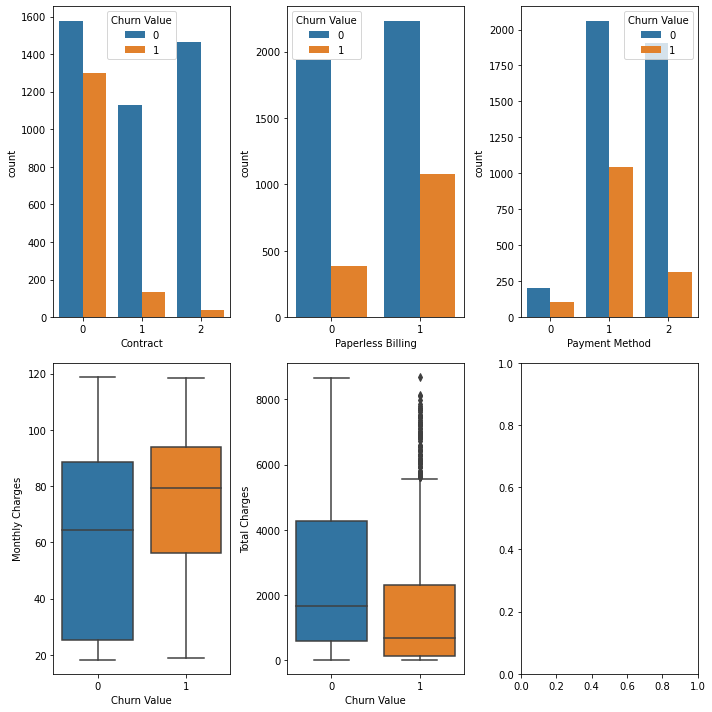

In [19]:
# visualize the distribution of all features vs churn value 
# using seaborn 

fig, ax = plt.subplots(2, 3, figsize=(10, 10))
sns.countplot(x='Contract', hue='Churn Value', data=train, ax=ax[0, 0])
sns.countplot(x='Paperless Billing', hue='Churn Value', data=train, ax=ax[0, 1])
sns.countplot(x='Payment Method', hue='Churn Value', data=train, ax=ax[0, 2])
# also identify the numbers on the boxplots
sns.boxplot(x='Churn Value', y='Monthly Charges', data=train, ax=ax[1, 0]) 
sns.boxplot(x='Churn Value', y='Total Charges', data=train, ax=ax[1, 1])
plt.tight_layout()
plt.show()



### Brief comment on the data (Initial Insights)
1. Contracts with long durations tend to have lower churn rates.
2. Customers with paperless billing tend to have higher churn rates.
3. Bank withdrawal payment method has the highest churn rate among all payment methods (which may indicate that there is a problem in the application coopearting with the bank), also there is a few poeple that prefer to pay with mailed check
4. People more likely to churn are those who pay between 80-90 or more dollars per month
5. People more likely to churn pay less than those who don't churn in total charges 

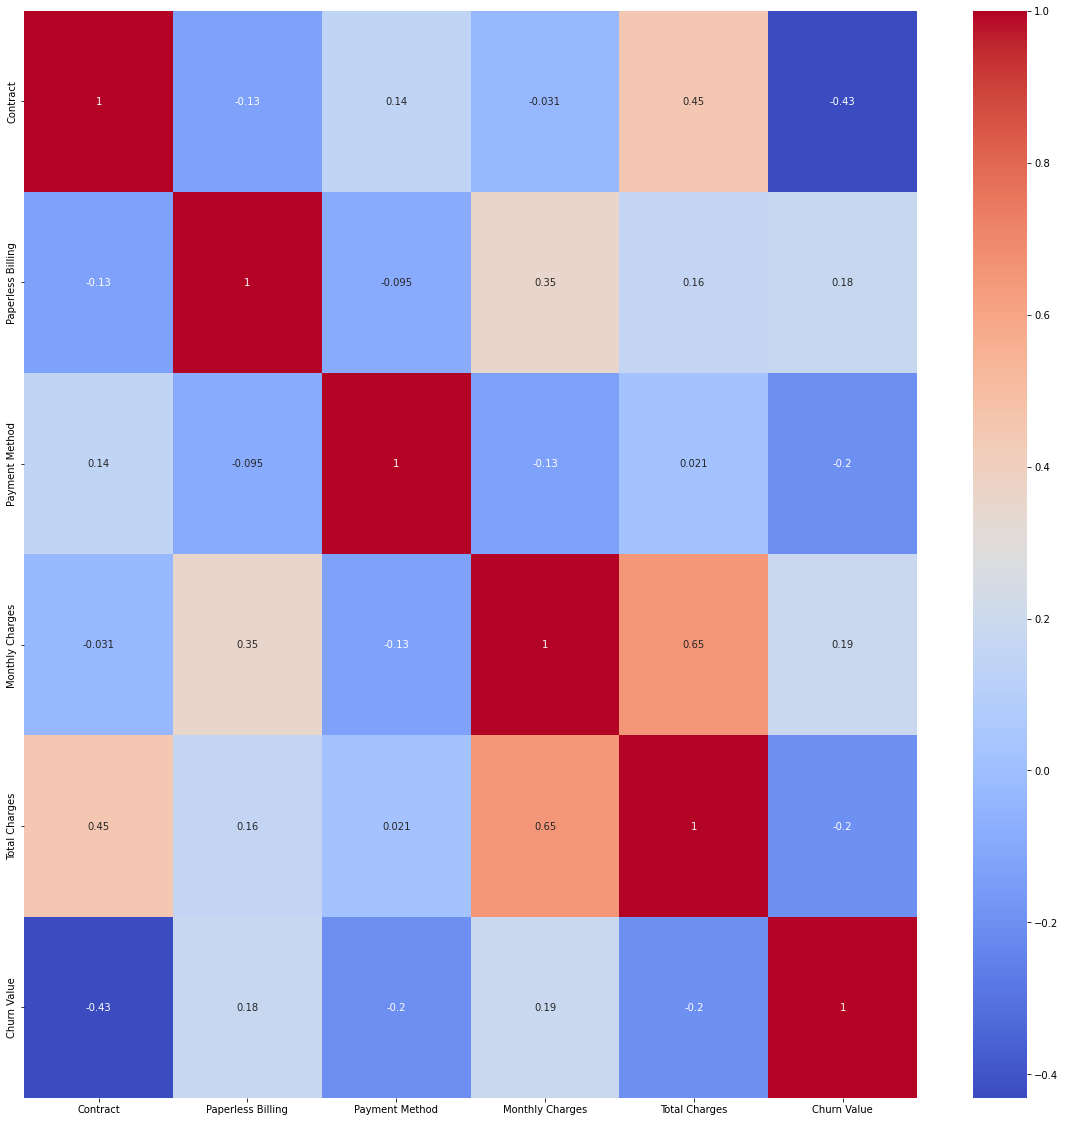

In [20]:
# check the correlation between the features
#visualize the correlation between the features
plt.figure(figsize=(20, 20))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.show()


### Brief comment on the correlation matrix
1. MonthlyCharges and Churn value are positively correlated
2. TotalCharges and Churn value are  negatively correlated
3. Contract and Churn Value are negatively correlated (longer contracts have lower churn rates)


So the visualizations and the correlation matrix show that the monthly charges, the total charges and Contract are the most important features that have a meaning in predicting the churn value.
But the other features are also important and can be used to improve the model.

#### Model building:

In [21]:
# Let's build a logistic regression model

# drop the target variable from the training set
X_train = train.drop('Churn Value', axis=1)

# select the target variable from the training set
y_train = train['Churn Value']

# drop the target variable from the test set
X_test = test.drop('Churn Value', axis=1)

# select the target variable from the test set
y_test = test['Churn Value']

# balance the training set
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Formal Modeling

### Logistic Regression Model

#### Expectations
The model should be able to predict the churn value with a high accuracy and use the features that are most important in predicting the churn value.
Most of the features are categorical so logistic regression is a good choice for this problem.

We expect that by dropping TotalCharges the model won't be affected as TotalCharges has very high correlation with other features so it's a redundant information.

In [22]:
# trying to use all features to build the model
logreg_giridSearch_crossValid(X_train, y_train, X_test, y_test)

Best Hyperparameters:  {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1009
           1       0.54      0.80      0.65       400

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.80      0.75      0.76      1409



In [23]:
# trying to improve the logistic regression model by using the low correlated features to avoid redundancy only and dropping the rest
logreg_giridSearch_crossValid(X_train[['Contract', 'Payment Method', 'Monthly Charges']], y_train, X_test[[
                              'Contract', 'Payment Method', 'Monthly Charges']], y_test)


Best Hyperparameters:  {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1009
           1       0.55      0.81      0.65       400

    accuracy                           0.75      1409
   macro avg       0.73      0.77      0.73      1409
weighted avg       0.80      0.75      0.77      1409



c:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Revise the Expectations
Data and Expectations matches

#### Interpret the Logistic Regression Model
##### all features case
1. The model has an accuracy of 75% which is good but not great
2. The model has a f1-score of 73% which is good
##### low correlated features case
1. The model has an accuracy of 75% which is good but not great
2. The model has a f1-score of 73% which is good

So all features is good but not great, and the low correlated features case is the same as the all features case w.r.t. the accuracy and f1-score.
##### Note
In low correlated case we removed 'Total charges' which is highly correlated with 'Monthly charges' and 'Contract'.
and the model didn't change much so we can say that 'Total charges' is a redundant information.

## Random Forest Model

In [24]:
# trying all features in the model
randomForest_giridSearch_crossValid(X_train, y_train, X_test, y_test)

Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1009
           1       0.56      0.77      0.65       400

    accuracy                           0.76      1409
   macro avg       0.73      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



In [25]:
# trying to improve the random forest model by using the low correlated features to avoid redundancy only and dropping the rest
randomForest_giridSearch_crossValid(X_train[['Contract', 'Payment Method', 'Monthly Charges']], y_train, X_test[[
                              'Contract', 'Payment Method', 'Monthly Charges']], y_test)

Best Hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1009
           1       0.55      0.77      0.64       400

    accuracy                           0.75      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.79      0.75      0.76      1409

